In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [3]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from scipy.stats import gamma, norm, beta, uniform
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver


from src.plotting import plot_dfs
from src.process_data import load_data
from src.filtering_sampling import set_up_kalman_filter, kalman_filter, sample_from_priors, solve_updated_mod, get_arr_pdf_from_dist
from src.utils import printProgBar

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [5]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_s', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_c': 'pi'})

# split train and test
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [8]:
rbc = gEconModel(os.path.join(MODEL_DIR, 'mod4_rbc.gcn'), verbose=False)
nkm = gEconModel(os.path.join(MODEL_DIR, 'mod5_nk_capital.gcn'), verbose=False)

In [9]:
_, rbc = solve_updated_mod(rbc, verbose=False)
assert _ == True
_, nkm = solve_updated_mod(nkm, verbose=False)
assert _ == True

In [16]:
mod = nkm
mod_params = nkm.free_param_dict.copy()

In [21]:
from scipy.stats import gamma, beta
prior_dist = {
    # 'alpha': beta(1.4, 10),
    # 'beta': beta(.9, 1.5),
    'sigma_C': gamma(a=3.9, loc=0, scale=0.757575757575758),
    'sigma_L': gamma(a=1.9, loc=0, scale=2.63157894736842),
    # 'eta_p': beta(2.4, 1.2),
    # 'eta_w': beta(2.4, 1.2),
    # 'phi_H': beta(1.2, 1.2),
    # 'epsilon_test': beta(1.2, 1.2),
    'epsilon_A': beta(1.2, 1.2),
    'epsilon_preference': beta(1.2, 1.2),
    'epsilon_R': beta(1.2, 1.2),
    'epsilon_T': beta(1.2, 1.2),
    'epsilon_Y': beta(1.2, 1.2),
    'epsilon_pi': beta(1.2, 1.2),
            }

#### my filter

In [ ]:
shock_names = [x.base_name for x in mod.shocks]
state_variables = [x.base_name for x in mod.variables]
observed_vars = ["Y"]

params, shocks = sample_from_priors(prior_dist, mod_params, shock_names)
mod.free_param_dict.update(params)
solved, mod = solve_updated_mod(mod, verbose=False)
if not solved: raise ValueError

T, R = mod.T.values, mod.R.values
mu, cov, ll, solved = kalman_filter(R, T, state_variables=state_variables, observed_vars=observed_vars, 
                                    shock_names=shock_names, shocks_drawn_prior=shocks, train_data=train)
if not solved: raise ValueError
print(ll.sum())

array must not contain infs or NaNs


..\src\filtering_sampling.py:110: RuntimeWarning: overflow encountered in matmul
  K = P @ Z.T @ F_chol
..\src\filtering_sampling.py:116: RuntimeWarning: invalid value encountered in matmul
  I_KZ = np.eye(K.shape[0]) - K @ Z


ValueError: 

In [ ]:
mu_df = pd.DataFrame(mu, index=train.index, columns=[item.base_name for item in mod.variables])
# plot_dfs([mu_df[train.columns], train], sns.lineplot, legend=['filter', 'data'])

### filterpy

In [24]:
shock_names = [x.base_name for x in mod.shocks]
state_variables = [x.base_name for x in mod.variables]
observed_vars = ["Y",]

params, shocks = sample_from_priors(prior_dist, mod_params, shock_names)
mod.free_param_dict.update(params)
solved, mod = solve_updated_mod(mod, verbose=False)
if not solved: raise ValueError


T, R = mod.T.values, mod.R.values
H, Z, T, R, QN, zs = set_up_kalman_filter(R=R, T=T, observed_data=train[observed_vars].values, observed_vars=observed_vars, 
                                          shock_names=shock_names, shocks_drawn_prior=shocks, state_variables=state_variables)

kfilter = KalmanFilter(len(state_variables), len(observed_vars))
kfilter.F = mod.T
kfilter.Q = QN
kfilter.H = Z
kfilter.R = H

In [25]:
saver = Saver(kfilter)
mu, cov, _, _ = kfilter.batch_filter(zs, saver=saver)
ll = saver.log_likelihood
print(np.sum(ll))
mu_df = pd.DataFrame(mu.reshape(len(mu), -1),
                     columns=[item.base_name for item in mod.variables],
                     index=train.index)

-532.5150197135001


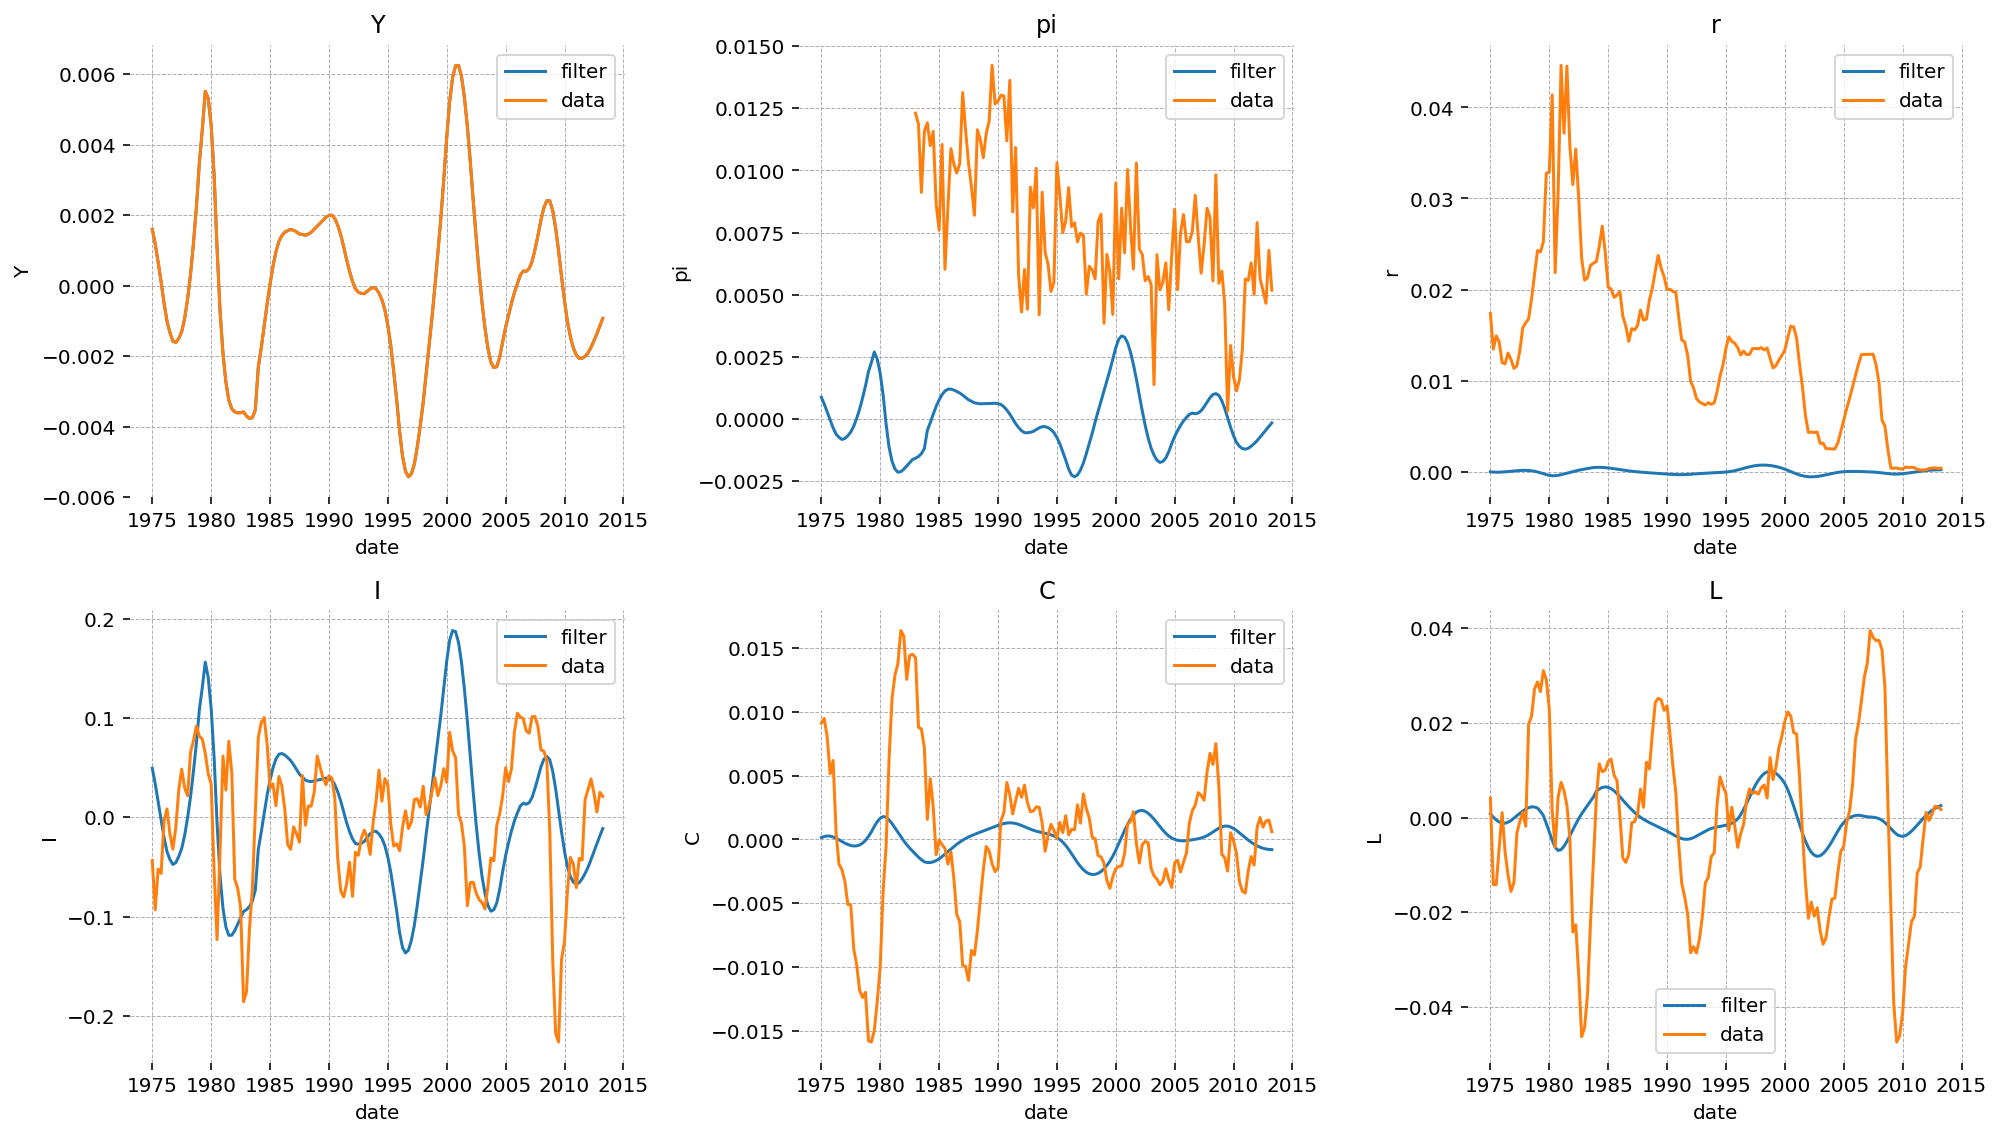

In [26]:
plot_dfs([mu_df[train.columns], train], sns.lineplot, legend=['filter', 'data'])